## Preprocessing and Dataset Statistics

In [1]:
import pandas as pd
import numpy as np
import re
import sklearn
from sklearn import cluster
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib as g
from sklearn.preprocessing import OneHotEncoder
import random
import scipy
import scipy.signal
import pickle

**Importing the Dataset**

In [2]:
movie = pd.read_pickle('cleaned_movie_set.pkl')
#movie = pd.read_csv("cleaned_movies.csv", encoding='utf-8') #this is just for Harvey to run locally
#movie = movie.drop(movie.columns[0], axis=1) # drop this after reading the pickle instead of cleaned_movies.csv #this is just for Harvey to run locally
movie.head()

,Title,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,...,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
0,#1 Cheerleader Camp (2010),0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,#chicagoGirl: The Social Network Takes on a Di...,1,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,#Horror (2015),0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,#Pellichoopulu (2016),0,0,0,0,0,1,0,0,1,...,0,0,1,0,0,0,0,0,0,0
4,"$1,000 on the Black (1966)",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


**Acquiring Genre Correlations**

In [3]:
df = movie
c = df.corr().abs()
s = c.unstack()
so = s.sort_values(ascending=False, kind="quicksort")
genre_corr = so[28::2]
genre_corr[0:28]

Drama        Documentary    0.274506
Animation    Short          0.260361
Adventure    Action         0.246525
Comedy       Drama          0.228739
Horror       Drama          0.223028
Adventure    Animation      0.215504
Comedy       Thriller       0.214372
Family       Animation      0.209395
Crime        Film-Noir      0.186115
Thriller     Horror         0.184386
Horror       Sci-Fi         0.172706
Documentary  Biography      0.171134
Biography    History        0.169102
Animation    Drama          0.162567
Mystery      Thriller       0.160600
Documentary  Comedy         0.160102
Crime        Action         0.157357
Sci-Fi       Drama          0.149632
Adventure    Drama          0.148040
Family       Adventure      0.147692
Horror       Mystery        0.144292
Documentary  News           0.140732
Music        Documentary    0.135527
Romance      Documentary    0.132402
             Comedy         0.129779
Drama        Romance        0.128822
Action       Sci-Fi         0.128365
 

**Acquiring Cumulative Sums and Label Counts**

In [4]:
counts = [] #getting the counts per genre
df = movie
genres = df.columns[2::]
for i in genres:
    counts.append(df[i].value_counts().to_dict())
#creating counts table
counts_df = pd.DataFrame.from_dict(counts)
counts_df[2] = genres
counts_table = counts_df.drop([0], axis=1)
counts_table = counts_table.rename(columns = {1:'counts', 2:'genre'})
counts_sort = counts_table.sort_values('counts', ascending=False)
#creating column of cumulative sums
sumcol = counts_sort['counts'].sum()
cumsum = counts_sort['counts']/sumcol
counts_sort['cumsum'] = cumsum
counts_sort

,counts,genre,cumsum
7,18168,Drama,0.246623
4,11490,Comedy,0.155972
19,5694,Romance,0.077294
5,4854,Crime,0.065891
24,4487,Thriller,0.060909
13,3770,Horror,0.051176
1,3518,Adventure,0.047755
6,3343,Documentary,0.045380
16,2223,Mystery,0.030176
8,1937,Family,0.026294


**Displaying Correlation Matrix**

In [5]:
df = movie.drop(df.columns[0], axis=1)
genres = movie.columns[1:].tolist()
genres_rev= genres[::-1]

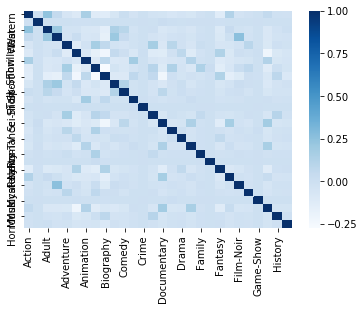

In [8]:
R = np.corrcoef(df,rowvar=0)
genre_heatmap = sb.heatmap(R,cmap = "Blues")
genre_heatmap.set_xticklabels(genres, rotation=90)
genre_heatmap.set_yticklabels(genres_rev)
plt.show(genre_heatmap)

**Removing Irrelevant Label Genres**

In [9]:
garb = counts_sort['genre'].where(counts_sort['cumsum']<.04).tolist()
garb = garb[9:28]
garb

['Family',
 'Sci-Fi',
 'Fantasy',
 'Biography',
 'Animation',
 'History',
 'Music',
 'War',
 'Short',
 'Western',
 'Musical',
 'Sport',
 'Film-Noir',
 'News',
 'Adult',
 'Talk-Show',
 'Reality-TV',
 'Game-Show']

In [10]:
clean_df = movie #clean dataset without garbage labels
clean_df = clean_df.drop(garb, axis=1) #removing the unwanted genres from our dataset
clean_df.head()

,Title,Action,Adventure,Comedy,Crime,Documentary,Drama,Horror,Mystery,Romance,Thriller
0,#1 Cheerleader Camp (2010),0,0,1,0,0,0,0,0,0,0
1,#chicagoGirl: The Social Network Takes on a Di...,1,0,0,0,1,1,0,0,0,0
2,#Horror (2015),0,0,0,0,0,1,1,1,0,0
3,#Pellichoopulu (2016),0,0,1,0,0,1,0,0,1,0
4,"$1,000 on the Black (1966)",0,0,0,0,0,0,0,0,0,0


**New Correlations after Removing Excess Labels**

In [11]:
#New Correlations after removing excess labels
c = clean_df.corr().abs()
s = c.unstack()
so = s.sort_values(ascending=False, kind="quicksort")
genre_corr = so[9::2]
genre_corr[0:12]

Action     Action         1.000000
Drama      Documentary    0.274506
Adventure  Action         0.246525
Comedy     Drama          0.228739
Horror     Drama          0.223028
Comedy     Thriller       0.214372
Horror     Thriller       0.184386
Thriller   Mystery        0.160600
Comedy     Documentary    0.160102
Crime      Action         0.157357
Adventure  Drama          0.148040
Mystery    Horror         0.144292
dtype: float64

**Dropping Non-Contextual Genres**

In [13]:
sixgenres = clean_df.drop(['Adventure', 'Documentary', 'Mystery','Drama'], axis=1)
sixgenres['sample']=0
sixgenres.head()

,Title,Action,Comedy,Crime,Horror,Romance,Thriller,sample
0,#1 Cheerleader Camp (2010),0,1,0,0,0,0,0
1,#chicagoGirl: The Social Network Takes on a Di...,1,0,0,0,0,0,0
2,#Horror (2015),0,0,0,1,0,0,0
3,#Pellichoopulu (2016),0,1,0,0,1,0,0
4,"$1,000 on the Black (1966)",0,0,0,0,0,0,0


**Checking Cumulative Sums after Removing Non-contextual Genres**

In [14]:
genres = sixgenres.columns[1:].tolist()
counts = []
for i in genres:
    counts.append(sixgenres[i].value_counts().to_dict())
counts_df = pd.DataFrame.from_dict(counts)
counts_df[2] = genres
counts_table = counts_df.drop([0], axis=1)
counts_table = counts_table.rename(columns = {1:'counts', 2:'genre'})
counts_sort = counts_table.sort_values('counts', ascending=False)
sumcol = counts_sort['counts'].sum()
cumsum = counts_sort['counts']/sumcol
counts_sort['cumsum'] = cumsum
counts_sort

,counts,genre,cumsum
1,11490.0,Comedy,0.325902
4,5694.0,Romance,0.161504
0,4961.0,Action,0.140714
2,4854.0,Crime,0.137679
5,4487.0,Thriller,0.127269
3,3770.0,Horror,0.106932
6,NaN,sample,NaN


**Downsamping Comedy to Balance Label Classes**

In [15]:
col_list = ['Action','Comedy','Crime','Horror','Romance','Thriller']
sixgenres['Empty'] = sixgenres[col_list].sum(axis = 1)
df = sixgenres[sixgenres.Empty != 0]
df.head()

,Title,Action,Comedy,Crime,Horror,Romance,Thriller,sample,Empty
0,#1 Cheerleader Camp (2010),0,1,0,0,0,0,0,1
1,#chicagoGirl: The Social Network Takes on a Di...,1,0,0,0,0,0,0,1
2,#Horror (2015),0,0,0,1,0,0,0,1
3,#Pellichoopulu (2016),0,1,0,0,1,0,0,2
6,$5 a Day (2008),0,1,0,0,0,0,0,1


In [16]:
comedy = df[df['Comedy'] == 1]
np.random.seed = 1
b = np.random.choice(comedy.Title,size = 4000, replace = False)
df2 = comedy[comedy['Title'].isin(b)]

In [17]:
df3 = df[(df['Title'].isin(df2.Title) & df['Comedy'] == 1) | (df['Comedy'] == 0)]

In [18]:
df3 = df[(df['Title'].isin(df2.Title) & df['Comedy'] == 1) | (df['Comedy'] == 0)]
df4 = df3.drop(df3.columns[-2:],axis= 1)
df4.head

<bound method NDFrame.head of                                                    Title  Action  Comedy  \
1      #chicagoGirl: The Social Network Takes on a Di...       1       0   
2                                         #Horror (2015)       0       0   
3                                  #Pellichoopulu (2016)       0       1   
10                                            '71 (2014)       1       0   
11                                            'D' (2005)       0       0   
13                            'Fun on a Week-End' (1947)       0       1   
14                                        'G' Men (1935)       0       0   
17                      'I Know Where I'm Going!' (1945)       0       0   
19                             'n Beetje Verliefd (2006)       0       1   
22                              'Pimpernel' Smith (1941)       0       0   
23                                        'R Xmas (2001)       0       0   
25                                  'Sheba, Baby' (1975)  

**Double-Checking Class Balance**

In [ ]:
genres = df4.columns[1:].tolist()
counts = []
for i in genres:
    counts.append(df4[i].value_counts().to_dict())
counts_df = pd.DataFrame.from_dict(counts)
counts_df[2] = genres
counts_table = counts_df.drop([0], axis=1)
counts_table = counts_table.rename(columns = {1:'counts', 2:'genre'})
counts_sort = counts_table.sort_values('counts', ascending=False)
sumcol = counts_sort['counts'].sum()
cumsum = counts_sort['counts']/sumcol
counts_sort['cumsum'] = cumsum
counts_sort